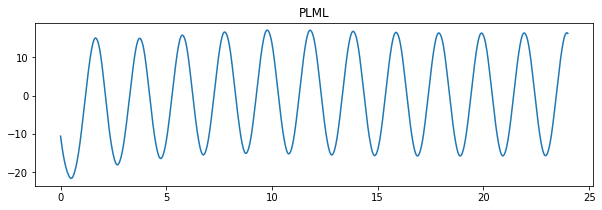

In [47]:
from util.neuron_metadata import *
from util.plot_util import *
import numpy as np
import pandas as pd
from neural_model import NeuralModel
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')

model = NeuralModel(neuron_metadata_collection)
model.seed = 0
model.set_current_injection("AVBL", 2.3)
model.set_current_injection("AVBR", 2.3)
model.set_current_injection("PLML", 1.4)
model.set_current_injection("PLMR", 1.4)
model.init()
(v_mat, s_mat, v_normalized_mat) = model.run(2700)
# The oscillatory dynamic doesn't stabilize until about dt*300 onwards.
# Also, interactome analysis is done after the first 50 timesteps.
fwd_dynamics = v_normalized_mat[300:,:]

# Plot one neuron just to show the oscillation
plot_saved_dynamics(['PLML'], fwd_dynamics, neuron_metadata_collection)

In [48]:
# Get all the motor neurons
motor_neurons = []
for id in range(neuron_metadata_collection.get_size()):
    if neuron_metadata_collection.get_metadata(id).neuron_type == NeuronType.MOTOR:
        motor_neurons.append(id)
        
# Worm atlas says 113: "A total of 113 of the 302 C. elegans neurons belong to the motor neuron category"
# But, we get 109 motor neurons. Close enough.
# Let's extract out just the motor neurons' time series.
fwd_motor_dynamics = fwd_dynamics[:,motor_neurons]
fwd_motor_dynamics.shape

(2400, 109)

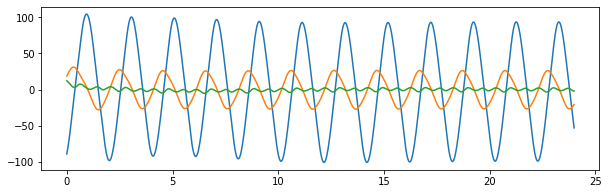

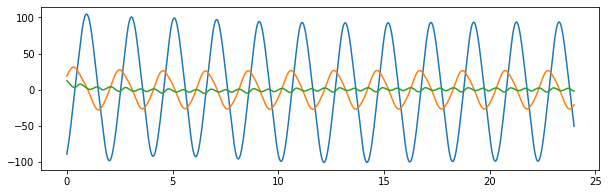

In [49]:
from sklearn.decomposition import PCA
# Perform mean-centering before PCA
X = fwd_motor_dynamics - fwd_motor_dynamics.mean(axis= 0)

pca = PCA(n_components=4)
projected_X = pca.fit_transform(X)
num_timesteps = fwd_motor_dynamics.shape[0]
times = np.arange(0, num_timesteps * 0.01 , 0.01)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(times, projected_X[:,0])
ax.plot(times, projected_X[:,1])
ax.plot(times, projected_X[:,2])

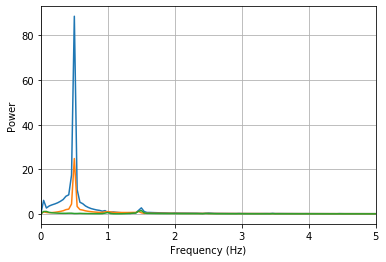

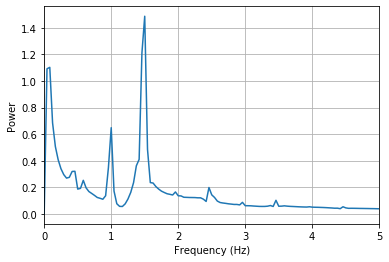

In [10]:
plot_principal_component_fft(n_components=3, projected=projected_X, t=0.01)

# plot just 3rd
projected = np.row_stack(projected_X[:, 2])
plot_principal_component_fft(1, projected, 0.01)

Primary oscillatory periods in seconds: [1.99833333 0.70529412 0.68514286 0.63105263 0.40644068 0.25242105
 0.23057692 0.22838095 0.22622642 0.22622642 0.218      0.21603604
 0.20672414 0.20322034 0.19983333 0.19818182 0.18446154 0.17895522
 0.17632353 0.1750365  0.17376812 0.15986667 0.14711656 0.13702857
 0.13248619 0.13175824 0.12962162 0.12962162 0.12823529 0.12297436
 0.109      0.10517544 0.10380952 0.09708502 0.09669355 0.09515873
 0.09367188 0.09117871 0.0824055  0.08212329 0.08074074 0.0804698
 0.07862295 0.07836601 0.07811075 0.07710611 0.07424149 0.07378462
 0.07310976 0.07222892 0.07201201 0.07115727 0.0697093  0.06890805
 0.0687106  0.06698324 0.06551913 0.06481081 0.06446237 0.06428954
 0.06180412 0.06164524 0.06148718 0.05935644 0.05920988 0.05906404
 0.05891892 0.05669031 0.05615925 0.05437642 0.05425339 0.05413093
 0.0530531  0.05213043 0.05179266 0.05037815 0.05027254 0.04864097
 0.04854251 0.04844444 0.04834677 0.04796    0.04786427 0.04776892
 0.04692759 0.04656311 

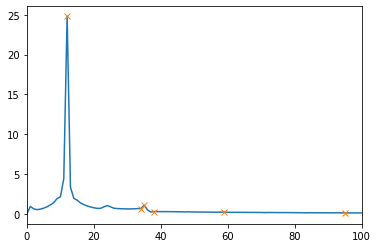

In [13]:
import scipy.signal as signal
from util.analysis_util import * 

projected = np.row_stack(projected_X[:, 1])

# find peaks of fft for computing pc oscillatory period
t = 0.01
N = len(projected)
pc_fft = fft(projected[:,0])
pc_fft_freq = np.linspace(0., 1./(2. * t), N//2)

widths = np.arange(1,10)
pc_fft_rs = np.reshape(pc_fft, (N))
pc_fft_rs = 2.0/N * np.abs(pc_fft_rs[0:N//2])
peaks = signal.find_peaks_cwt(pc_fft_rs, widths, min_length=1)

# plot
fig, ax = plt.subplots()
ax.set_xlim(0, 100)
ax.plot(pc_fft_rs)
ax.plot(peaks, pc_fft_rs[peaks], "x")

# use util fn
pers = get_dominant_periods(projected, t)
print("Primary oscillatory periods in seconds: " + str(pers))

Dominant frequency: 0.5004170141784821 Hz
Primary oscillatory period: 1.9983333333333333 sec


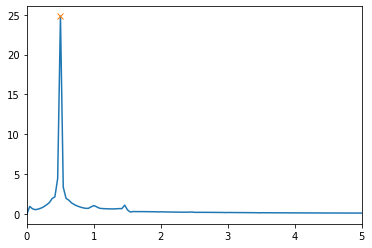

In [75]:
# find single dominant peak of fft and compute oscillatory period
t = 0.01
projected = np.row_stack(projected_X[:, 1])
(pc_fft, pc_fft_freq) = get_fft(projected[:,0], t)
peak = np.where(pc_fft == np.amax(pc_fft))
freq_1 = pc_fft_freq[peak]

# plot
fig, ax = plt.subplots()
ax.set_xlim(0, 5)
ax.plot(pc_fft_freq, pc_fft)
ax.plot(freq_1, pc_fft[peak], "x")

# use util fn
per_1 = get_dominant_period(projected, t)

print("Dominant frequency: " + str(freq_1[0]) + " Hz")
print("Primary oscillatory period: " + str(per_1) + " sec")

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(projected_X[:,0], projected_X[:,1], times)

ax.set_title("First two SVD modes", fontsize=15)
ax.set_xlabel('Mode 1', fontsize=10)
ax.set_ylabel('Mode 2', fontsize=10)
ax.set_zlabel('Time (s)', fontsize=10)

In [52]:
# Confirm that pca.singular_values really are singular values.
# https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
# Yep, they match. pca.singular_values really are the singular values from SVDs, NOT the PC eigenvalues.
n = X.shape[0]
C = np.dot(X.T, X) / (n-1)
eigen_vals, eigen_vecs = np.linalg.eig(C)
eigen_vals[0]
(pca.singular_values_ ** 2 / (n-1)) [0:3]

array([4361.64928494,  344.15058727,    5.02451987])

In [53]:
eigen_vals[0:3]

array([4361.64928494,  344.15058727,    5.02451987])

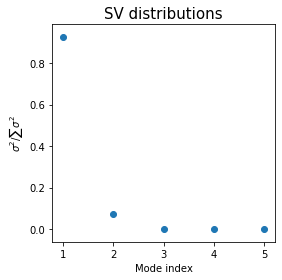

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sigma_squared = np.square(pca.singular_values_)
sigma_squared_normed = sigma_squared / sum(sigma_squared)

ax.set_title("SV distributions", fontsize=15)
x_labels = list(range(1, 6))
ax.scatter(x_labels, sigma_squared_normed[:5])
ax.set_xlabel('Mode index', fontsize=10)
ax.set_ylabel('$\sigma^2 / \sum\sigma^2$', fontsize=10)
_ = ax.set_xticks(x_labels)

In [58]:
sigma_squared_normed[0]

0.9246342048836335

In [59]:
sigma_squared_normed[1]

0.07295712787435163